# <span style="color:MidnightBlue  ">  *Clusterização* de documentos </span>


<span style="color:MediumTurquoise "> **Verifica e instala pacotes** </span>

In [12]:
if(!require('proxy')) install.packages('proxy')
if(!require('RTextTools')) install.packages("RTextTools", type="source")
if(!require('fpc')) install.packages('fpc')

Loading required package: RTextTools
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘RTextTools’”Warning message:
“package ‘RTextTools’ is not available (for R version 3.5.1)”Loading required package: fpc


<span style="color:MediumTurquoise "> **Carrega Bibliotecas** </span>

In [72]:
library(tm)
library(proxy)
# library(RTextTools)
library(fpc)   
library(wordcloud)
library(cluster)
library(tm)
library(stringi)
library(wordcloud)

<span style="color:MediumTurquoise "> **Carrega Dados** </span>

In [65]:
path = "/home/brenda/git/text-mining-with-R/"
dir = DirSource(paste(path,"/movies/",sep=""), encoding = "UTF-8")
#corpus = Corpus(dir, readerControl=list(reader=readPDF))
corpus = Corpus(dir)
summary(corpus)

                       Length Class             Mode
A Era do Gelo          2      PlainTextDocument list
A Era do Gelo 2        2      PlainTextDocument list
A Era do Gelo 3        2      PlainTextDocument list
Meu Malvado Favorito   2      PlainTextDocument list
Meu Malvado Favorito 2 2      PlainTextDocument list
Minions                2      PlainTextDocument list
Mulan                  2      PlainTextDocument list
Pocahontas             2      PlainTextDocument list
Procurando Dory        2      PlainTextDocument list
Procurando Nemo        2      PlainTextDocument list
Rei Leão               2      PlainTextDocument list
Rei Leão 2             2      PlainTextDocument list
Shrek                  2      PlainTextDocument list
Shrek 2                2      PlainTextDocument list

<span style="color:MediumTurquoise "> **Matriz de Termos por Documento (DTM)** </span>

DTM é uma matriz que lista todas as ocorrências de palavras no *corpus*. Os documentos são representados por linhas e os termos (ou palavras) por colunas.
Se uma palavra ocorrer em um documento específico n vezes, a entrada da matriz correspondente a essa linha e coluna será n, se ela não ocorrer, a entrada será 0.

In [73]:
ndocs <- length(corpus)
# ignore extremely rare words i.e. terms that appear in less then 1% of the documents
minTermFreq <- ndocs * 0.01
# ignore overly common words i.e. terms that appear in more than 50% of the documents
maxTermFreq <- ndocs * .5
dtm = DocumentTermMatrix(corpus,
                         control = list(
                                        stopwords = TRUE, 
                                        wordLengths=c(4, 15),
                                        removePunctuation = T,
                                        removeNumbers = T,
                                        #stemming = T,
                                        bounds = list(global = c(minTermFreq, maxTermFreq))
                                       ))
#dtm <- dtm[, names(head(sort(colSums(as.matrix(dtm))), 400))]
#dtm <- dtm[, names(sort(colSums(as.matrix(dtm))))]
#print(as.matrix(dtm))
write.csv((as.matrix(dtm)), "test.csv")
#head(sort(as.matrix(dtm)[18,], decreasing = TRUE), n=15)
dtm.matrix = as.matrix(dtm)
#wordcloud(colnames(dtm.matrix), dtm.matrix[28, ], max.words = 20)

In [67]:
inspect(dtm)

<<DocumentTermMatrix (documents: 14, terms: 2249)>>
Non-/sparse entries: 3319/28167
Sparsity           : 89%
Maximal term length: 15
Weighting          : term frequency (tf)
Sample             :
                        Terms
Docs                     diego dory fiona manny marlin nemo reino scar shrek
  A Era do Gelo             14    0     0    15      0    0     0    0     0
  A Era do Gelo 2            9    0     0    11      0    0     0    0     0
  A Era do Gelo 3            8    0     0    13      0    0     0    0     0
  Meu Malvado Favorito 2     0    0     0     0      0    0     0    0     0
  Mulan                      0    0     0     0      0    0     0    0     0
  Procurando Dory            0   29     0     0     11   13     0    0     0
  Rei Leão                   0    0     0     0      0    0    12   19     0
  Rei Leão 2                 0    0     0     0      0    0     5    6     0
  Shrek                      0    0    17     0      0    0     1    0    21
  Shr

<span style="color:MediumTurquoise "> **Term Frequency–Inverse Document Frequency (TF-IDF)** </span>

No DTM percebe-se que os termos que ocorrem com frequência têm um alto valor associado. No entanto, a alta frequência de um determinado termo em um documento significa pouco se esses termos aparecerem com frequência em outros documentos no corpus. Em outras palavras, os termos que ocorrem com freqüência em um documento, mas não com frequência dentro do corpus, recebem uma ponderação mais alta, uma vez que se supõe que essas palavras contenham mais significado em relação ao documento.

Para conseguir isso, diminui-se os termos que ocorrem com frequência nos documentos. Isso é feito calculando as estatísticas do **tf-idf**.

In [68]:
#dtm <- weightTfIdf(dtm, normalize = TRUE)
dtm.matrix = as.matrix(dtm)
#wordcloud(colnames(dtm.matrix), dtm.matrix[28, ], max.words = 20)
#inspect(dtm)
write.csv((as.matrix(dtm)), "test.csv")

- Lista dos termos mais importantes para o **Rei Leão**, conforme determinado usando a ponderação tf-idf.

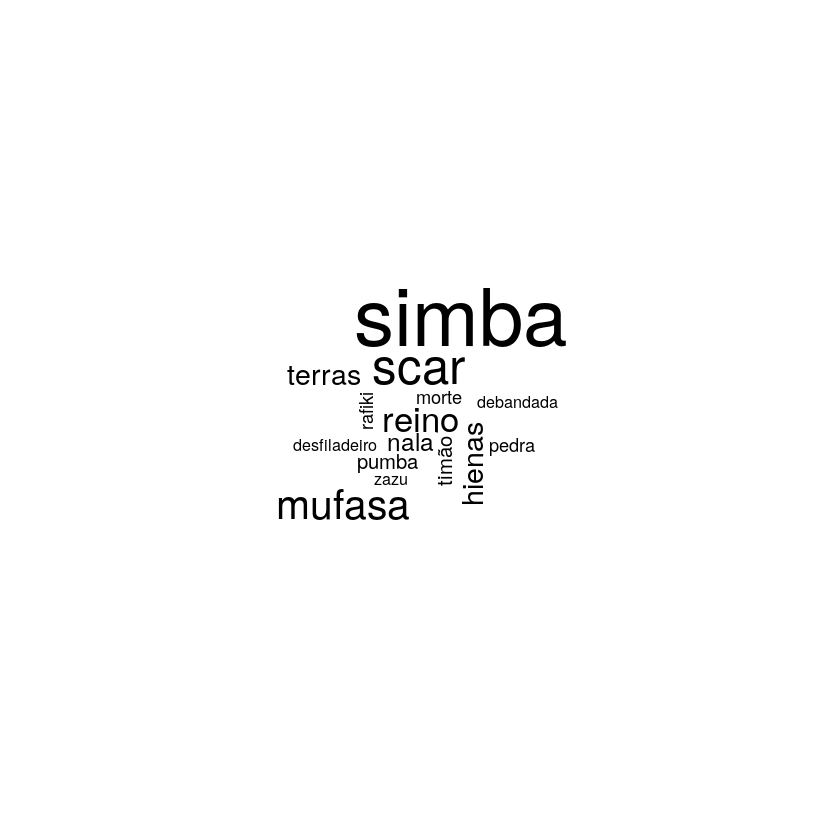

In [69]:
#head(sort(as.matrix(dtm)[1,], decreasing = TRUE), n=13)
wordcloud(colnames(dtm.matrix), dtm.matrix[11, ], max.words = 200)

- Calcula a distância *euclidiana/cosseno* entre os documentos. Essa distância é o que o algoritmo de *Clustering* usa para **agrupar** documentos.

In [70]:
m  <- as.matrix(dtm)
# # # m <- m[1:2, 1:3]
# distMatrix <- dist(m, method="euclidean")
#print(distMatrix)
distMatrix <- dist(m, method="cosine")
#print(distMatrix)

## <span style="color:MidnightBlue  "> **Clustering** </span>


<span style="color:MediumTurquoise"> **Clustering Hierárquico** </span>

Atribuir cada documento ao seu próprio cluster (membro único)
Encontre o par de clusters mais próximos entre si (dist) e mescle-os. Então você agora tem um cluster menor que antes.
Calcule as distâncias entre o novo cluster e cada um dos clusters antigos.
Repita as etapas 2 e 3 até que você tenha um único cluster contendo todos os documentos.

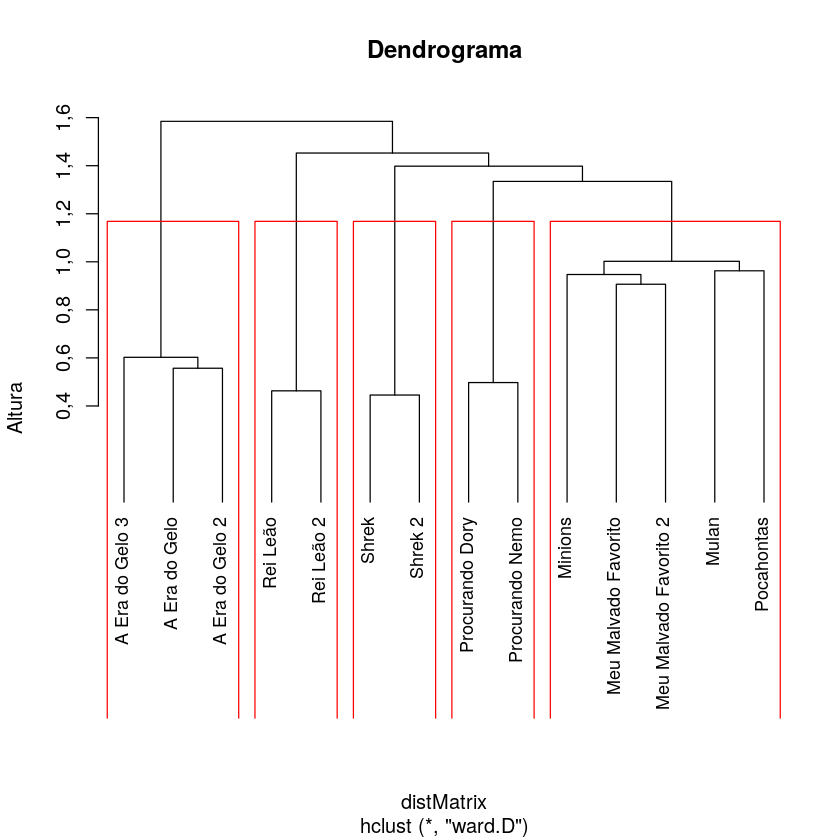

In [78]:
groups <- hclust(distMatrix,method="ward.D")
plot(groups, cex=0.9, hang=-1, main='Dendrograma', ylab='Altura')
rect.hclust(groups, k=5)